# Symplectic versus non-symplectic integrators

In [1]:
using Plots
using LinearAlgebra
using ForwardDiff: gradient, derivative

## Define Hamiltonian system

In [3]:
H(q,p) = 1/2*p^2 - 1/2*sin(q)
H(z) = H(z[1],z[2])

H (generic function with 2 methods)

In [133]:
Jinv = [0 1; -1 0];
XH(z) = Jinv*gradient(H,z)
Hq(q,p) = derivative(q->H(q,p),q)
Hp(q,p) = derivative(p->H(q,p),p)

Hp (generic function with 1 method)

## Numerical Integrators

In [136]:
# fixpoint iterations
function FixIter(fun,z,minStepSize)
    while true
        zold = z
        z = fun(z)
        norm(zold - z) > minStepSize || break
    end
    return z
end

FixIter (generic function with 1 method)

In [137]:
# definition of several numerical integrators

function Euler(h,z)
    return z+h*XH(z)
end

function SympEuler(h,z)
    R(deltaQ) = h*Hp(z[1]+deltaQ,z[2])
    deltaQ=FixIter(R,0.,1e-12)
    q = z[1]+deltaQ
    p = z[2]-h*Hq(q,z[2])
    return [q;p]
end


function MidPoint(h,z)
    R(delta) = h*XH(z + 1/2*delta)
    delta=FixIter(R,zeros(size(z)),1e-12)
    return z + delta
end

# repreated application of integrator
function Integrator(numFlow,z,steps)
    Z = zeros(2,steps+1)
    Z[:,1] = z
    for k = 1:size(Z,2)-1
        Z[:,k + 1] = numFlow(Z[:,k])
    end
    return Z
end

Integrator (generic function with 1 method)

## Numerical Experiements - Dynamics and energy preservation

In [7]:
z0 = [0.5,0.]
h = 0.4
T = 20
steps = ceil(Int,T/h)
tt = range(0,T,steps+1)

0.0:0.4:20.0

In [8]:
ZEuler=Integrator(z->Euler(h,z),z0,steps)
ZSympEuler=Integrator(z->SympEuler(h,z),z0,steps)
ZMidPoint=Integrator(z->MidPoint(h,z),z0,steps);

### Phase plot - symplectic vs non-symplectic

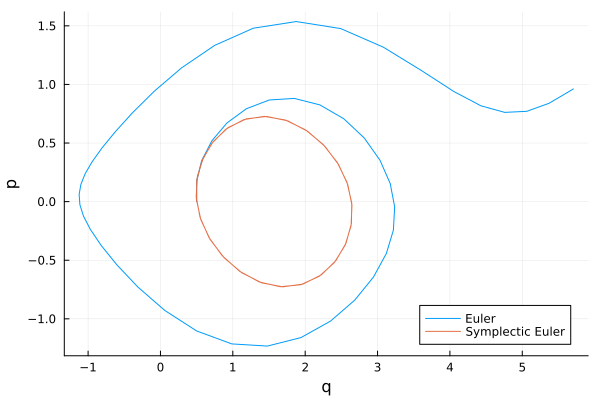

In [9]:
plot(ZEuler[1,:],ZEuler[2,:],label="Euler",xlabel="q",ylabel="p")
plot!(ZSympEuler[1,:],ZSympEuler[2,:],label="Symplectic Euler")
#plot!(ZMidPoint[1,:],ZMidPoint[2,:])

### energy preservation - symplectic vs non-symplectic

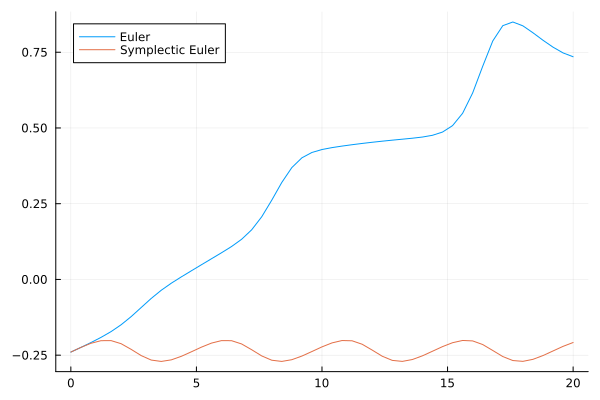

In [10]:
plot(tt,mapslices(H,ZEuler,dims=1)',label="Euler")
plot!(tt,mapslices(H,ZSympEuler,dims=1)',label="Symplectic Euler")

### Long term energy conservation of the Symplectic Euler method

In [11]:
stepsLong=Int(1e7) #1e7
ZSympEulerLong=Integrator(z->SympEuler(h,z),z0,stepsLong);
ttLong = range(0,stepsLong*h,stepsLong+1);

In [12]:
energyLong = mapslices(H,ZSympEulerLong,dims=1)';

In [13]:
sparseSkip = 2000
ttSparse = ttLong[1:sparseSkip:end]
energySparse = energyLong[1:sparseSkip:end];

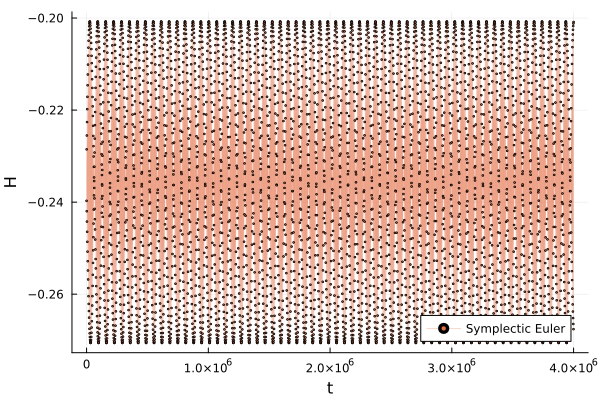

In [14]:
plot(ttSparse,energySparse,label="Symplectic Euler",color=:2,linewidth=0,marker=:circle, markersize=1,xlabel="t",ylabel="H")

## Numerical Experiments - Comparison of exact and numerical phase portraits for symplectic integrators

In [143]:
# plotting tools

function PlotSympEl!(plotHandle,z0,steps)
    ZSympEuler = Integrator(z->SympEuler(h,z),z0,steps)
    plotHandle=plot!(ZSympEuler[1,:],ZSympEuler[2,:],label="",color=:black)
end

function PlotSymplElScale!(plotHandle,scales,z0,steps)
    for s in scales
        PlotSympEl!(plotHandle,s*z0,steps)
    end
end

PlotSymplElScale! (generic function with 1 method)

In [145]:
# phase space
qq = range(-2,5,40)
pp = range(-pi/2,pi/2,30)
#contour(

-1.5707963267948966:0.10833078115826873:1.5707963267948966

In [146]:
# initial values for numerical integration with a symplectic integrator
z0Phase = [pi/2,0]
stepsContour=50;
scales= (0.2:0.2:3)

0.2:0.2:3.0

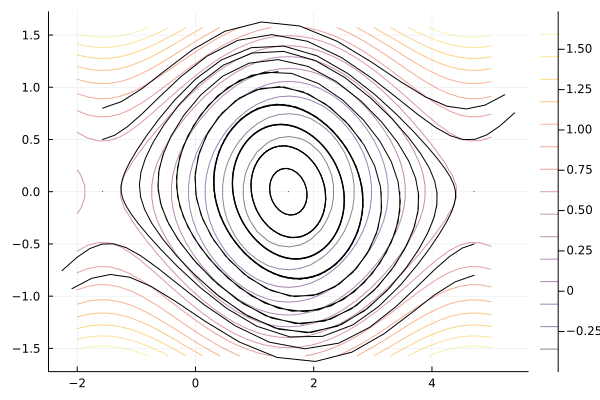

In [147]:
# plots
pl = contour(qq,pp,H.(qq',pp),alpha=0.5);
PlotSymplElScale!(pl,scales,z0Phase,stepsContour)
PlotSympEl!(pl,[-pi/2,0],stepsContour)
PlotSympEl!(pl,[-pi/2,0.5],20)
PlotSympEl!(pl,[-pi/2,0.8],15)
PlotSympEl!(pl,[3*pi/2,-0.5],20)
PlotSympEl!(pl,[3*pi/2,-0.8],15)
pl

In [131]:
#savefig(pl,"PhasePlot_SymplEuler.pdf")